# GILL Decision Classifier

At least ~18GB of GPU memory is required to run this model, and it has only been tested on A6000, V100, and 3090 GPUs.

In [1]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import torch
from torch import nn
import torchmetrics
from tqdm import notebook

from gill import models
from gill import utils

## Load the Model

Note that you will need to download the [CC3M image embeddings](https://drive.google.com/file/d/1e9Cimh2dpWN8Cbgx_mSR-954Dr-DS-ZO/view) and place them in the `checkpoints/gill_opt/` folder, in order to use GILL's image retrieval capabilities. If this embedding file does not exist, we will not use the retrieval score as a feature for the decision classifier, and results may be slightly different from the paper.

In [2]:
# Download the model checkpoint and embeddings to checkpoints/gill_opt/
model_dir = 'checkpoints/gill_opt/'
model = models.load_gill(model_dir, decision_model_fn=None)

cc3m.npy files do not exist in checkpoints/gill_opt/.
Running the model without retrieval.
Adding [IMG0] token to vocabulary.
Before adding new token, tokenizer("[IMG0]") = {'input_ids': [10975, 3755, 534, 288, 742], 'attention_mask': [1, 1, 1, 1, 1]}
After adding 1 new tokens, tokenizer("[IMG0]") = {'input_ids': [50266], 'attention_mask': [1]}
Adding [IMG1] token to vocabulary.
Before adding new token, tokenizer("[IMG1]") = {'input_ids': [10975, 3755, 534, 134, 742], 'attention_mask': [1, 1, 1, 1, 1]}
After adding 1 new tokens, tokenizer("[IMG1]") = {'input_ids': [50267], 'attention_mask': [1]}
Adding [IMG2] token to vocabulary.
Before adding new token, tokenizer("[IMG2]") = {'input_ids': [10975, 3755, 534, 176, 742], 'attention_mask': [1, 1, 1, 1, 1]}
After adding 1 new tokens, tokenizer("[IMG2]") = {'input_ids': [50268], 'attention_mask': [1]}
Adding [IMG3] token to vocabulary.
Before adding new token, tokenizer("[IMG3]") = {'input_ids': [10975, 3755, 534, 246, 742], 'attention_mask

/scratch/jingyuk/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Freezing the LM.
Restoring pretrained weights for the visual model.
Freezing the VM.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


# Load PartiPrompts

Load the preprocessed PartiPrompts annotations, after discarding examples with low interannotator agreement. Please see `scripts/process_p2_annotations.py` for more details.

In [3]:
dec2idx = {'gen': 0, 'ret': 1, 'same': 2}
idx2dec = {v: k for k, v in dec2idx.items()}

with open('data/PartiPromptsDecisionsConfident.tsv', 'r') as f:
    captions = []
    decisions = []

    for i, line in enumerate(f.readlines()[1:]):
        data = line.strip().split('\t')
        captions.append(data[0])
        decisions.append(dec2idx[data[4]])

assert len(captions) == len(decisions)
print(len(captions))

1632


## Extract Embeddings from GILL

In [4]:
all_embeddings = []
all_labels = []

# Create special token string, to let us extract the IMG token features.
img_inp = ''
for i in range(model.model.num_tokens):
    img_inp += f'[IMG{i}]'

for i in notebook.tqdm(range(len(captions))):
    caption = captions[i]

    caption = caption + img_inp
    inp_tokens = model.model.tokenizer(caption, add_special_tokens=True, return_tensors="pt")
    inp_tokens_ids = inp_tokens.input_ids.cuda()
    inp_caption_len = inp_tokens.attention_mask[0].sum(0, keepdim=True).cuda()

    # Dummy images, since we are only running the captions.
    images = torch.zeros((1, 3, 224, 224)).bfloat16().cuda()
    
    if idx2dec[decisions[i]] != 'same':
        with torch.no_grad():
            _, _, _, _, _, _, _, llm_embedding = model(
                images, inp_tokens_ids, inp_caption_len, mode='generation', concat_captions=False)
            all_embeddings.append(llm_embedding[0].float().detach().cpu().numpy())
            all_labels.append(decisions[i])

  0%|          | 0/1632 [00:00<?, ?it/s]

## Train a Decision Model

  0%|          | 0/2000 [00:00<?, ?it/s]

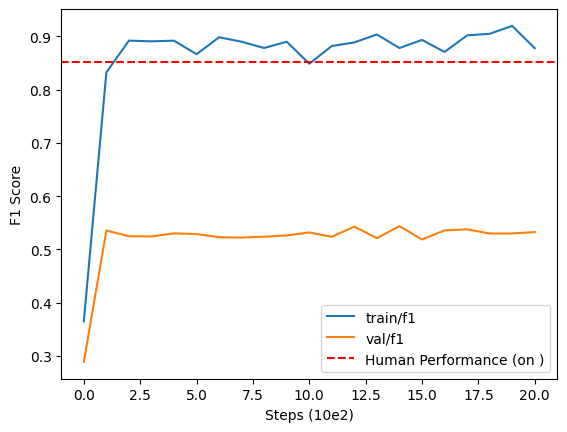

Best F1: 0.5436410903930664
Last F1: 0.5325511693954468


In [5]:
num_train = 600  # Use 600 examples for training and the remaining for validation
all_f1s = []
torch.manual_seed(1337)
f1 = torchmetrics.F1Score(task='multiclass', num_classes=2, average='macro').cuda()

# Concatenate examples for training the decision model.
features = np.concatenate(all_embeddings, axis=0)[:, 0, :]
train_data = torch.tensor(features[:num_train, :]).float().cuda()
train_labels = torch.tensor(all_labels[:num_train], dtype=torch.long).cuda()
test_data = torch.tensor(features[num_train:, :]).float().cuda()
test_labels = torch.tensor(all_labels[num_train:], dtype=torch.long).cuda()

# Create decision model.
decision_clf = nn.Sequential(*[
    nn.Dropout(0.5),
    nn.Linear(features.shape[1], 2),
])
decision_clf = decision_clf.cuda()
optimizer = torch.optim.AdamW(decision_clf.parameters(), lr=1e-3, weight_decay=0, eps=1e-8)


# Start the training loop.
num_steps = 2000
ce_loss = nn.CrossEntropyLoss()
plots = collections.defaultdict(list)

for i in notebook.tqdm(range(num_steps)):
    train_preds = decision_clf(train_data)
    loss = ce_loss(train_preds, train_labels)

    if i % 100 == 0 or i == num_steps - 1:
        decision_clf.eval()
        train_f1 = f1(train_preds, train_labels).item()
        best = 0
        worst = 1
        best_thresh = None

        # We use 0.5 as the threshold for classification.
        # Optionally sweep over np.linspace(0, 1, num=50) to find the best threshold.
        for thresh in [0.5]:
            test_preds = decision_clf(test_data)
            test_preds = (torch.nn.functional.softmax(test_preds, dim=-1) > thresh).float()
            curr_f1 = f1(test_preds, test_labels).item()
            if curr_f1 > best:
                best = curr_f1
                best_thresh = thresh
            if curr_f1 < worst:
                worst = curr_f1
        decision_clf.train()

        plots['train/loss'].append(loss.item())
        plots['train/f1'].append(train_f1)
        plots['val/f1'].append(best)
        plots['val/cutoff'].append(best_thresh)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

for k, v in plots.items():
    if 'f1' in k:
        plt.plot(v, label=k)

plt.axhline(y=0.8510681024099351, color='r', linestyle='--', label='Human Performance (val)')
plt.ylabel('F1 Score')
plt.xlabel('Steps (10e2)')

plt.legend()
plt.show()
print('Best F1:', np.max(plots['val/f1']))
print('Last F1:', plots['val/f1'][-1])

Finally, we can save the decision model to disk (and later on, load it for inference).

In [8]:
output_path = os.path.join(model_dir, 'decision_model.pth.tar')
with open(output_path, 'wb') as wf:
    torch.save({
        'state_dict': decision_clf.state_dict()
    }, wf)
    print('Saved to', output_path)

Saved to checkpoints/gill_opt/decision_model.pth.tar
